In [1]:
import csv
import mmh3
import numpy as np

In [2]:
csv_file = open('processed_dataset_separated.csv', newline='', encoding='utf-8')
reader = csv.reader(csv_file, delimiter=',')

max_tracks = 100

playlist_names = []
artists = []
tracks = []
albums = []
for row in reader:
    if row[0] == 'playlist_name': continue
    
    playlist_names.append(row[0])
    
    read_list = row[5:5+max_tracks]
    while '' in read_list: read_list.remove('')
    artists.append(read_list)
    
    read_list = row[5+max_tracks:5+2*max_tracks]
    while '' in read_list: read_list.remove('')
    tracks.append(read_list)
    
    read_list = row[5+2*max_tracks:5+3*max_tracks]
    while '' in read_list: read_list.remove('')
    albums.append(read_list)

csv_file.close()

In [3]:
artist_shingles = []
track_shingles = []
album_shingles = []
for i in range(len(playlist_names)):
    artist_shingles.append(set(artists[i]))
    track_shingles.append(set(tracks[i]))
    album_shingles.append(set(albums[i]))

In [4]:
def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val
def minhash(shingles: list, k: int):
    minhashes = []
    for i in range(k):
        minhashes.append(-1)
        for shingle in shingles:
            currenthash = listhash([shingle], i)
            if(currenthash < minhashes[i] or minhashes[i] == -1):
                minhashes[i] = currenthash
    return minhashes

In [5]:
k = 50
artist_hashes = []
track_hashes = []
album_hashes = []
for i in range(len(playlist_names)):
    artist_hashes.append(minhash(artist_shingles[i], k))
    track_hashes.append(minhash(track_shingles[i], k))
    album_hashes.append(minhash(album_shingles[i], k))

In [6]:
def jaccard(list1: list, list2: list):
    crosssection = len(set(list1).intersection(list2))
    return crosssection / (len(list1) + len(list2) - crosssection)

In [7]:
artist_similarity_matrix = np.empty((len(playlist_names), len(playlist_names)))
np.fill_diagonal(artist_similarity_matrix, 1)
track_similarity_matrix = np.empty((len(playlist_names), len(playlist_names)))
np.fill_diagonal(track_similarity_matrix, 1)
album_similarity_matrix = np.empty((len(playlist_names), len(playlist_names)))
np.fill_diagonal(album_similarity_matrix, 1)

In [8]:
for i in range(len(playlist_names)):
    for j in range(i+1, len(playlist_names)):
        
        artist_similarity = jaccard(artist_hashes[i], artist_hashes[j])
        artist_similarity_matrix[i,j] = artist_similarity
        artist_similarity_matrix[j,i] = artist_similarity
        
        track_similarity = jaccard(track_hashes[i], track_hashes[j])
        track_similarity_matrix[i,j] = track_similarity
        track_similarity_matrix[j,i] = track_similarity
        
        album_similarity = jaccard(album_hashes[i], album_hashes[j])
        album_similarity_matrix[i,j] = album_similarity
        album_similarity_matrix[j,i] = album_similarity

In [9]:
artist_similarities = []
track_similarities = []
album_similarities = []
for i in range(len(playlist_names)):
    for j in range(i+1, len(playlist_names)):
        artist_similarities.append(artist_similarity_matrix[i,j])
        track_similarities.append(track_similarity_matrix[i,j])
        album_similarities.append(album_similarity_matrix[i,j])

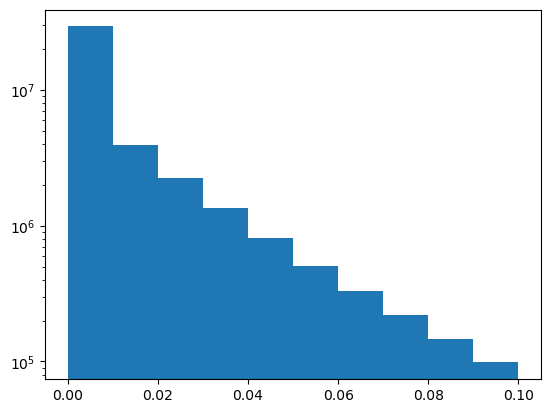

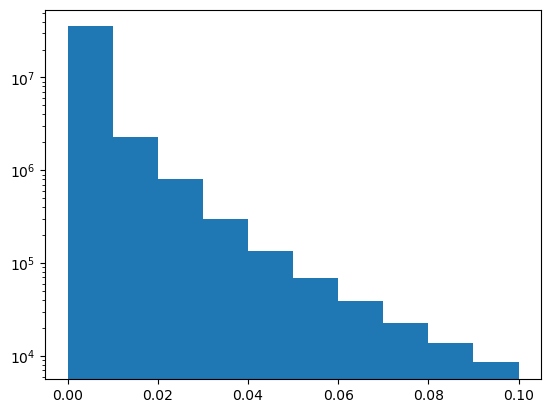

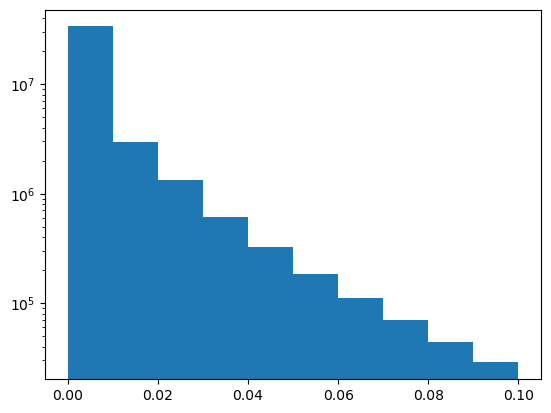

In [10]:
import matplotlib.pyplot as plt
bins = np.arange(0,0.11,0.01)
plt.hist(artist_similarities, bins, log=True)
plt.show()
plt.hist(track_similarities, bins, log=True)
plt.show()
plt.hist(album_similarities, bins, log=True)
plt.show()

In [11]:
artist_similarity_csv_file = open('artist_similarity.csv', 'w', newline='', encoding='utf-8')
artist_similarity_writer = csv.writer(artist_similarity_csv_file)
track_similarity_csv_file = open('track_similarity.csv', 'w', newline='', encoding='utf-8')
track_similarity_writer = csv.writer(track_similarity_csv_file)
album_similarity_csv_file = open('album_similarity.csv', 'w', newline='', encoding='utf-8')
album_similarity_writer = csv.writer(album_similarity_csv_file)

first_row = [''] + playlist_names
artist_similarity_writer.writerow(first_row)
track_similarity_writer.writerow(first_row)
album_similarity_writer.writerow(first_row)

82486

In [12]:
for i in range(len(playlist_names)):
    
    artist_similarity_writer.writerow([playlist_names[i]] + list(artist_similarity_matrix[i]))
    track_similarity_writer.writerow([playlist_names[i]] + list(track_similarity_matrix[i]))
    album_similarity_writer.writerow([playlist_names[i]] + list(album_similarity_matrix[i]))
    
artist_similarity_csv_file.close()
track_similarity_csv_file.close()
album_similarity_csv_file.close()